### Necessary Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import math
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from tensorflow.keras.models import Sequential
# from keras.layers.convolutional import Conv1D
# from keras.layers.convolutional import MaxPooling1D
from keras.utils import to_categorical
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv1D, Conv2D, MaxPooling1D,MaxPooling2D, LSTM


### Load Dataset

## Github Data

In [2]:
def moving_average(df, window_size):
    """"
    Compute the moving average with a window of size specified
    """

    rolling_mean = df.rolling(window=window_size).mean()
    downsampled = rolling_mean.iloc[window_size::window_size, :]
    return downsampled

In [3]:
import os

def read_files(data_path):
    # current_path = os.path.dirname(os.path.abspath(__file__))
    # data_path = os.path.join(current_path, '/data/dl_data')

    # Create an empty list to store the dataframes
    dfs = []
    labels = []
    min = 0
    max = 128
    start_sample = 5000
    end_sample = 10000
    window_size = 20

    # Loop over files in the folder
    for filename in tqdm(os.listdir(data_path)):

        # Get the full path of the file
        file_path = os.path.join(data_path, filename)

        # If file exists then start operating
        if os.path.isfile(file_path):

            # Read file without header as there is no column name
            df = pd.read_csv(file_path,header=None)
            
            # Remove first column i.e. timestamp. Then select 64 subcarriers
            # Perform moving average of 10 rows
            df = moving_average(df.iloc[start_sample:end_sample+1, min+1:max+1],window_size)  
            
            # Store label based on the file selected
            if "standup" in file_path:
                labels.append("StandUp")
            elif "sitdown" in file_path:
                labels.append("SitDown")
            elif "walk" in file_path:
                labels.append("Walk")
            elif "run" in file_path:
                labels.append("Run")

            # Append the new dataframe to the list        
            dfs.append(df.values.tolist())
    return dfs, labels

In [4]:
data_path = "C:\\Users\\Dell\\Documents\\Wifi-Sensing-HAR\\data\\dl_data"
data, labels = read_files(data_path)

100%|██████████| 319/319 [05:06<00:00,  1.04it/s]


In [5]:
print(len(data), len(labels))

319 319


In [6]:
target_shape = np.array(data[0]).shape
target_shape

(250, 128)

In [7]:
def convert_csi_to_amplitude_phase(list_of_df):
    total_amplitudes = []
    total_phases = []
    # csi_string =my_Dataframe.tolist()
    csi_string = list_of_df

    for i, value in enumerate(csi_string):
        imaginary = []
        real = []
        amplitudes = [] 
        phases = []
        min=0
        max=128
        
        if "[" in value:
            # Remove [ and ] if exists
            value = value.strip("[]")

            # Parse string to create integer list
            csi_raw = [int(x) for x in value.split(" ") if x != ''][min:max]
            # csi_raw = [float(x) for x in value.split(",") if x!='']  # New
        else:
            csi_raw = value[min:max]

        # Create list of imaginary and real numbers from CSI
        [imaginary.append(csi_raw[item]) if item%2==0 else real.append(csi_raw[item]) for item in range(len(csi_raw))]

        # Transform imaginary and real into amplitude and phase
        val = int(len(csi_raw)//2)
        for k in range(val):
            amplitudes.append(round(math.sqrt(float(imaginary[k])** 2 + float(real[k])** 2),4))
            phases.append(round(math.atan2(float(imaginary[k]), float(real[k])),4))
        total_amplitudes.append(np.array(amplitudes).flatten())
        total_phases.append(np.array(phases).flatten())
        # print("-------------------")
        # print("Csi_Amplitude#{}:".format(i), amplitudes)
        # print("Csi_Phase#{}:    ".format(i), phases)
        
    return total_amplitudes, total_phases

# ## Amplitude Difference
# df = pd.DataFrame(np.vstack(total_amplitudes))
# diff_df = df.diff()[1:]   # Inorder to remove NaN values
# df.iloc[:,4:61]

amplitudes = []
phases = []
for df in tqdm(data):
    amps, phase = convert_csi_to_amplitude_phase(df)
    shape_amp = np.array(amps).shape
    ## Make data uniform
    amps = amps[:target_shape[0]]
    # amp_df = pd.DataFrame(np.vstack(amps))
    # phase_df = pd.DataFrame(np.vstack(phase))
    amplitudes.append(amps)
    phases.append(phase)

100%|██████████| 319/319 [00:48<00:00,  6.56it/s]


-------

### Load and find time differences of data samples of Github Data

0.0010000000000012221 0.0009999999999976694 0.001 1.505225610897138e-15


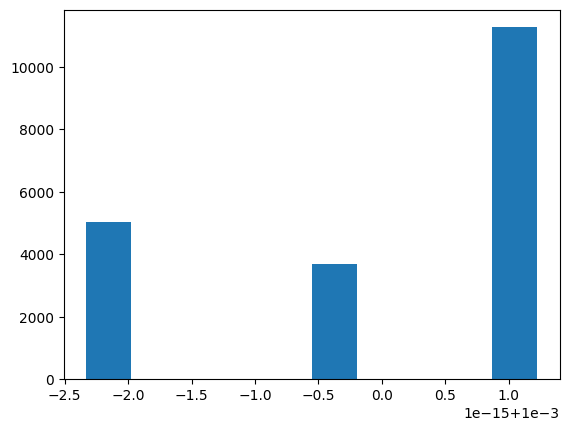

In [8]:
fall = pd.read_csv("data/input_fall_170314_0934_12.csv",header=None)
# fall_label = pd.read_csv("data/annotation_fall_170314_0934_12.csv",header=None,names=['label'])

# new_fall = pd.concat([fall, fall_label], axis=1)
# new_fall.head()

diffs = np.diff(fall[0])
plt.hist(diffs)

print(np.max(diffs),np.min(diffs),np.mean(diffs),np.std(diffs))

In [9]:
def moving_average(df, window_size):
    """"
    Compute the moving average with a window of size specified
    """

    rolling_mean = df.rolling(window=window_size).mean()
    downsampled = rolling_mean.iloc[window_size::window_size, :]
    return downsampled

# req_df = fall.iloc[:, 1:-1]  # First column is timestamp

In [10]:
np.array(amplitudes[0]).shape

(250, 64)

### Raw Samples Plot


In [ ]:
### Select one antenna 0-60 and timeframe where activity occured.
def raw_sample_plot(downsampled):
    # low_range = int(len(downsampled)/5)
    # high_range = int(len(downsampled)/5*2.5)
    # data = downsampled.iloc[low_range:high_range,0:60]
    raw_sample = downsampled

    fig1 = plt.figure(figsize = (18,20))

    ax1 = plt.subplot(611)
    plt.plot(raw_sample.iloc[:,0],'r')
    plt.plot(raw_sample.iloc[:,1],'g')
    plt.plot(raw_sample.iloc[:,2],'b')
    plt.plot(raw_sample.iloc[:,3],'cyan')
    plt.plot(raw_sample.iloc[:,4],'brown')
    ax1.set_title("Signal Value 1 to 5 subcarrier")

    ax2 = plt.subplot(612)
    plt.plot(raw_sample.iloc[:,5],'r')
    plt.plot(raw_sample.iloc[:,6],'g')
    plt.plot(raw_sample.iloc[:,7],'b')
    plt.plot(raw_sample.iloc[:,8],'cyan')
    plt.plot(raw_sample.iloc[:,9],'brown')
    ax2.set_title("Signal Value 6 to 10 subcarrier")

    ax3 = plt.subplot(613)
    plt.plot(raw_sample.iloc[:,10],'r')
    plt.plot(raw_sample.iloc[:,11],'g')
    plt.plot(raw_sample.iloc[:,12],'b')
    plt.plot(raw_sample.iloc[:,13],'cyan')
    plt.plot(raw_sample.iloc[:,14],'brown')
    ax3.set_title("Signal Value 11 to 15 subcarrier")

    ax4 = plt.subplot(614)
    plt.plot(raw_sample.iloc[:,15],'r')
    plt.plot(raw_sample.iloc[:,16],'g')
    plt.plot(raw_sample.iloc[:,17],'b')
    plt.plot(raw_sample.iloc[:,18],'cyan')
    plt.plot(raw_sample.iloc[:,19],'brown')
    ax4.set_title("Signal Value 16 to 20 subcarrier")

    ax5 = plt.subplot(615)
    plt.plot(raw_sample.iloc[:,20],'r')
    plt.plot(raw_sample.iloc[:,21],'g')
    plt.plot(raw_sample.iloc[:,22],'b')
    plt.plot(raw_sample.iloc[:,23],'cyan')
    plt.plot(raw_sample.iloc[:,24],'brown')
    ax5.set_title("Signal Value 21 to 25 subcarrier")

    ax6 = plt.subplot(616)
    plt.plot(raw_sample.iloc[:,25],'r')
    plt.plot(raw_sample.iloc[:,26],'g')
    plt.plot(raw_sample.iloc[:,27],'b')
    plt.plot(raw_sample.iloc[:,28],'cyan')
    plt.plot(raw_sample.iloc[:,29],'brown')
    ax6.set_title("Signal Value 25 to 30 subcarrier")

    plt.show()

In [ ]:
### Create a df of the list of list and make visualization
for lst in amplitudes:
    df = pd.DataFrame(np.vstack(lst))
    # diff_df = df.diff()[1:]   # Inorder to remove NaN values
    raw_sample_plot(df.iloc[:,4:61])
    break
    
    

In [ ]:
for lst in phases:
    df = pd.DataFrame(np.vstack(lst))
    # diff_df = df.diff()[1:]   # Inorder to remove NaN values
    raw_sample_plot(df.iloc[:,4:61])
    break

### PCA Visualization

In [ ]:
### Select one antenna 0-60 and timeframe where activity occured.
from sklearn.decomposition import PCA

def pca_visualization(downsampled):
    # low_range = int(len(downsampled)/5)
    # high_range = int(len(downsampled)/5*2.5)
    # data = downsampled.iloc[low_range:high_range,0:60]
    data = downsampled
    pca = PCA(n_components=5)
    pca.fit(data)
    new_sample = pca.transform(data)
    new_sample

    fig2 = plt.figure(figsize = (18,20))

    ax1 = plt.subplot(611)
    plt.plot(new_sample[:,0])
    ax1.set_title("PCA 1st component")

    ax2 = plt.subplot(612)
    plt.plot(new_sample[:,1])
    ax2.set_title("PCA 2nd component")

    ax3 = plt.subplot(613)
    plt.plot(new_sample[:,2])
    ax3.set_title("PCA 3rd component")

    ax4 = plt.subplot(614)
    plt.plot(new_sample[:,3])
    ax4.set_title("PCA 4th component")

    ax5 = plt.subplot(615)
    plt.plot(new_sample[:,4])
    ax5.set_title("PCA 5th component")

    # ax6 = plt.subplot(616)
    # plt.plot(new_sample[:,5])
    # ax6.set_title("PCA 6th component")

    plt.show()

In [ ]:
### Create a df of the list of list and make visualization
for lst in amplitudes:
    df = pd.DataFrame(np.vstack(lst))
    # diff_df = df.diff()[1:]   # Inorder to remove NaN values
    pca_visualization(df.iloc[:,4:61])
    break

In [ ]:
### Create a df of the list of list and make visualization
for lst in phases:
    df = pd.DataFrame(np.vstack(lst))
    # diff_df = df.diff()[1:]   # Inorder to remove NaN values
    pca_visualization(df.iloc[:,4:61])
    break

### Number of components to select for PCA


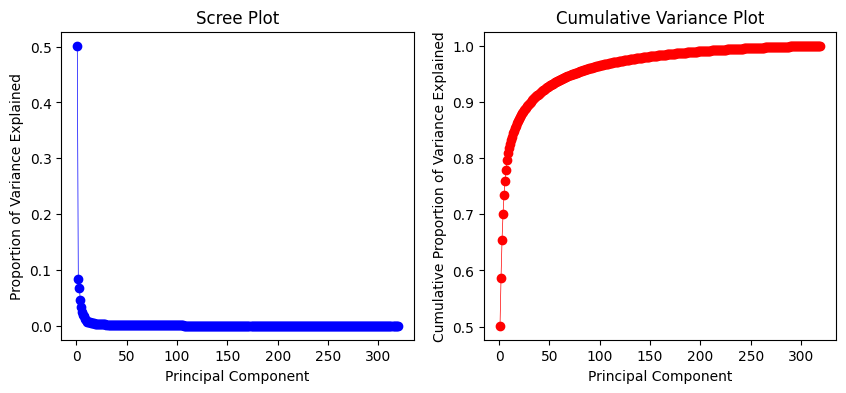

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_digits
from sklearn.decomposition import PCA

# load the dataset
# fit the PCA model with different numbers of principal components
pca = PCA()
scaler = StandardScaler()
flattened_amps = [np.array(amp).reshape(-1) for amp in amplitudes]
scaled_data = scaler.fit_transform(np.array(flattened_amps))
pca.fit(scaled_data)
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
n_components = range(1, pca.n_components_+1)

# plot the scree plot and cumulative variance plot
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
ax[0].plot(n_components, pca.explained_variance_ratio_, 'bo-', linewidth=0.5)
ax[0].set_title('Scree Plot')
ax[0].set_xlabel('Principal Component')
ax[0].set_ylabel('Proportion of Variance Explained')

ax[1].plot(n_components, cumulative_variance, 'ro-', linewidth=0.5)
ax[1].set_title('Cumulative Variance Plot')
ax[1].set_xlabel('Principal Component')
ax[1].set_ylabel('Cumulative Proportion of Variance Explained')

# find the ideal number of principal components based on the elbow method
diff = np.diff(pca.explained_variance_ratio_)
elbow = np.argmax(diff) + 1

### Model Creation Git Data

In [14]:
def load_data(filename):
    """
    Load data from a file.
    """
    data = np.loadtxt(filename, delimiter=",")
    X = data[:, :-1]
    y = data[:, -1]
    return X, y


def preprocess_data(X):
    """
    Preprocess data by scaling it using StandardScaler.
    """
    scaler = StandardScaler()
    X = scaler.fit_transform(np.array(X))
    return scaler, X

def perform_pca(X, n_components):
    """
    Perform PCA on the data.
    """
    pca = PCA(n_components=n_components)
    pca.fit(X)
    new_sample = pca.transform(X)
    return pca, new_sample

def train_test_split_data(X, y, test_size=0.2, random_state=42):
    """
    Split data into training and testing sets.
    """
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
    return X_train, X_test, y_train, y_test


def train_svm(X_train, y_train):
    """
    Train SVM model using the training data.
    """
    svm = SVC()
    svm.fit(X_train, y_train)
    return svm


def train_knn(X_train, y_train):
    """
    Train KNN model using the training data.
    """
    knn = KNeighborsClassifier()
    knn.fit(X_train, y_train)
    return knn


def train_cnn(X_train, y_train):
    """
    Train CNN model using the training data.
    """
    X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
    cnn = Sequential()
    cnn.add(Conv1D(64, 3, activation='relu', input_shape=(X_train.shape[1], 1)))
    cnn.add(MaxPooling1D(pool_size=2))
    cnn.add(Flatten())
    cnn.add(Dense(1, activation='sigmoid'))
    cnn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    cnn.fit(X_train, y_train, epochs=10, batch_size=32)
    return cnn


def train_lstm(X_train, y_train):
    """
    Train LSTM model using the training data.
    """
    X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
    lstm = Sequential()
    lstm.add(LSTM(64, input_shape=(X_train.shape[1], 1)))
    lstm.add(Dense(len(set(labels)), activation='softmax'))
    lstm.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    lstm.fit(X_train, y_train, epochs=10, batch_size=32)
    return lstm


def train_model(model_type, X_train, y_train):
    """
    Train model of given type using the training data.
    """
    if model_type == 'svm':
        model = train_svm(X_train, y_train)
    elif model_type == 'knn':
        model = train_knn(X_train, y_train)
    elif model_type == 'cnn':
        model = train_cnn(X_train, y_train)
    elif model_type == 'lstm':
        model = train_lstm(X_train, y_train)
    else:
        raise ValueError('Invalid model type.')
    return model


def test_model(model, X_test):
    """
    Evaluate the trained model on the testing data.
    """ 
    label = model.predict(X_test)
    return label

def evaluate_model(model, X_test, y_test):
    """
    Evaluate the trained model on the testing data.
    """ 
    score = model.score(X_test, y_test)
    return score

### KNN and SVM

In [15]:
flattened_amps = [np.array(amp).reshape(-1) for amp in amplitudes]
scalar_obj, scaled_data = preprocess_data(flattened_amps)

# Perform 10 components PCA
n_components = 100
pca_obj, pca_data = perform_pca(scaled_data,n_components)
pca_data

array([[ 68.43859937,  -1.92987234,  51.22177174, ...,  -1.79494799,
          3.22758435,   0.58076856],
       [ 39.02956366, -21.02311219,  40.74988003, ...,  -2.68764184,
          3.60818802,  -0.30707196],
       [ 66.6888808 , -11.21004105,  55.03500751, ...,   3.67480717,
         -2.72142248,   0.9724728 ],
       ...,
       [-59.24840682,   1.88322156,  14.58508779, ...,  -0.83356719,
          4.00803531,  -0.79819249],
       [-63.48078592, -18.42784186,   8.8074445 , ...,   0.92434589,
         -5.7447746 ,  -0.86156615],
       [-61.65334091, -14.91787236,   7.57225032, ...,   0.43793094,
          0.29896587,   0.17221776]])

In [16]:
np.array(scaled_data).shape

(319, 16000)

In [18]:
np.unique(np.array(labels), return_counts=True)

(array(['Run', 'SitDown', 'StandUp', 'Walk'], dtype='<U7'),
 array([80, 80, 79, 80], dtype=int64))

In [19]:
X_train, X_test, y_train, y_test = train_test_split(pca_data, labels, test_size=0.25,stratify=labels)
print(X_train)

[[ 2.96544597e+01 -3.89771378e+01  3.10130940e+01 ...  2.11949320e+00
   7.39641143e-01 -1.26474526e+00]
 [-2.57655984e+01 -2.35217206e+01 -1.24828209e+01 ...  2.46526002e-02
  -3.08107271e+00 -1.04703816e+00]
 [-6.85071318e+01 -3.47192309e+00 -5.41411045e+01 ... -4.00113956e+00
   4.24128094e-01  1.36767929e-01]
 ...
 [ 8.56285620e+01 -1.62537530e+01  3.70464319e+01 ...  5.17174159e-01
  -6.73338373e+00  1.75769256e+00]
 [-5.15579360e+01 -1.27042785e+01  3.53143329e+01 ... -1.39629976e+00
   2.79594838e-01 -2.74731565e+00]
 [-3.10847501e+01  3.02952435e+01 -1.23202197e+01 ... -3.01169888e+00
  -3.37484854e+00 -2.02076534e+00]]


In [20]:
svm = train_model('svm', X_train, y_train)
y_pred = test_model(svm, X_test)
print(evaluate_model(svm, X_test, y_test))
confusion_matrix(y_test, y_pred)

0.9375


array([[16,  0,  0,  4],
       [ 0, 20,  0,  0],
       [ 0,  0, 19,  1],
       [ 0,  0,  0, 20]], dtype=int64)

In [21]:
knn = train_model('knn', X_train, y_train)
y_pred = test_model(knn, X_test)
print(evaluate_model(knn, X_test, y_test))
confusion_matrix(y_test, y_pred)

0.95


array([[17,  0,  3,  0],
       [ 0, 20,  0,  0],
       [ 0,  0, 20,  0],
       [ 1,  0,  0, 19]], dtype=int64)

### CNN

In [23]:
np.array(amplitudes).shape

(319, 250, 64)

In [24]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
label_val=le.fit_transform(labels)

# le.inverse_transform(label_val)

In [25]:

X_train, X_test, y_train, y_test = train_test_split(amplitudes, label_val, test_size=0.2,stratify=labels)

print(np.array(X_train).shape, np.array(X_test).shape, np.array(y_train).shape, np.array(y_test).shape)

X_train_shape = np.array(X_train).shape
X_train = np.array(X_train).reshape(len(X_train), X_train_shape[1], X_train_shape[2],1)
X_test = np.array(X_test).reshape(len(X_test), X_train_shape[1], X_train_shape[2],1)
print(np.array(X_train).shape, np.array(X_test).shape)


(255, 250, 64) (64, 250, 64) (255,) (64,)
(255, 250, 64, 1) (64, 250, 64, 1)


In [26]:
model = Sequential()
model.add(Conv2D(filters=32, kernel_size=(3,3), activation='relu', input_shape=(X_train.shape[1],X_train.shape[2],1)))
model.add(Conv2D(filters=8, kernel_size=(3,3), activation='relu'))
model.add(Dropout(0.5))
model.add(MaxPooling2D(pool_size=(2,2), strides=2, padding="same"))
model.add(Flatten())
model.add(Dense(100, activation='relu'))
model.add(Dense(len(set(labels)), activation='softmax'))
# sparse_categorical_crossentropy
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 248, 62, 32)       320       
                                                                 
 conv2d_1 (Conv2D)           (None, 246, 60, 8)        2312      
                                                                 
 dropout (Dropout)           (None, 246, 60, 8)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 123, 30, 8)       0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 29520)             0         
                                                                 
 dense (Dense)               (None, 100)               2952100   
                                                        

In [27]:
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import h5py

# erl_stop = EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True)
# mod_chk = ModelCheckpoint(filepath='/my_cnn_model.hdf5', monitor='val_loss', save_best_only=True)
# lr_rate = ReduceLROnPlateau(monitor='val_loss', patience=3, factor=0.1)

In [28]:
print(np.array(X_train).shape, np.array(y_train).shape)
print(np.array(X_test).shape, np.array(y_test).shape)

(255, 250, 64, 1) (255,)
(64, 250, 64, 1) (64,)


In [29]:
obtained_model = model.fit(np.array(X_train), np.array(y_train), epochs=20, batch_size = 32 , validation_data = (X_test, y_test),callbacks= EarlyStopping(monitor='val_loss'), verbose=1)

Epoch 1/20
8/8 [==============================] - 10s 938ms/step - loss: 91.1221 - accuracy: 0.2235 - val_loss: 4.6095 - val_accuracy: 0.2344
Epoch 2/20
8/8 [==============================] - 7s 897ms/step - loss: 3.6162 - accuracy: 0.2941 - val_loss: 1.3097 - val_accuracy: 0.4062
Epoch 3/20
8/8 [==============================] - 7s 864ms/step - loss: 1.2084 - accuracy: 0.4941 - val_loss: 1.2126 - val_accuracy: 0.6562
Epoch 4/20
8/8 [==============================] - 7s 887ms/step - loss: 0.8406 - accuracy: 0.7529 - val_loss: 1.0715 - val_accuracy: 0.6719
Epoch 5/20
8/8 [==============================] - 7s 933ms/step - loss: 0.5386 - accuracy: 0.8275 - val_loss: 1.0215 - val_accuracy: 0.7188
Epoch 6/20
8/8 [==============================] - 7s 909ms/step - loss: 0.4294 - accuracy: 0.8980 - val_loss: 1.3578 - val_accuracy: 0.7031


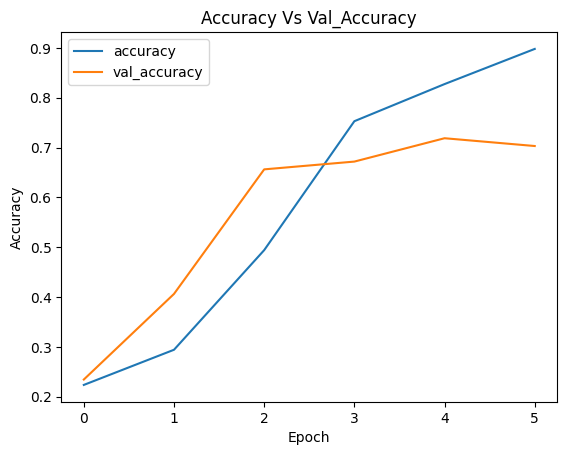

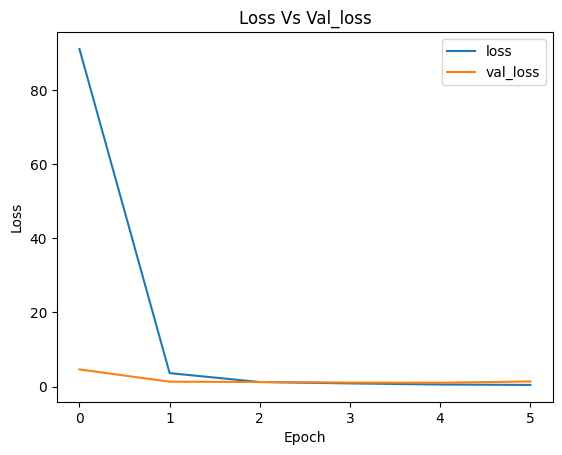

In [30]:
plt.plot(obtained_model.history['accuracy'])
plt.plot(obtained_model.history['val_accuracy'])
plt.legend(["accuracy","val_accuracy"])
plt.title('Accuracy Vs Val_Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

plt.plot(obtained_model.history['loss'])
plt.plot(obtained_model.history['val_loss'])
plt.legend(["loss","val_loss"])
plt.title('Loss Vs Val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [31]:
### 1D CNN


### LSTM

In [33]:
X_train, X_test, y_train, y_test = train_test_split(amplitudes, label_val, test_size=0.2,stratify=labels)
print(np.array(X_train).shape, np.array(X_test).shape, np.array(y_train).shape, np.array(y_test).shape)


X_train_shape = np.array(X_train).shape
X_train = np.array(X_train).reshape(len(X_train), -1, 1)
X_test = np.array(X_test).reshape(len(X_test), -1, 1)
print(np.array(X_train).shape, np.array(X_test).shape)


(255, 250, 64) (64, 250, 64) (255,) (64,)
(255, 16000, 1) (64, 16000, 1)


In [34]:
# pca_data = np.array(pca_data)
# X_train = pca_data.reshape(X_train.shape[0], X_train.shape[1], 1)
lstm = Sequential()
lstm.add(LSTM(64, input_shape=(X_train.shape[1], 1)))
lstm.add(Dense(len(set(labels)), activation='softmax'))
lstm.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
lstm.fit(X_train, y_train, epochs=10, batch_size=32)


Epoch 1/10
8/8 [==============================] - 115s 14s/step - loss: 1.4323 - accuracy: 0.2667
Epoch 2/10
8/8 [==============================] - 243s 32s/step - loss: 1.3943 - accuracy: 0.2627
Epoch 3/10
8/8 [==============================] - 239s 30s/step - loss: 1.3842 - accuracy: 0.2667
Epoch 4/10
8/8 [==============================] - 222s 28s/step - loss: 1.3828 - accuracy: 0.2392
Epoch 5/10
6/8 [=====================>........] - ETA: 1:02 - loss: 1.3861 - accuracy: 0.2604

In [ ]:
y_pred = lstm.predict(X_test)
score(y_pred,y_test)

## Our Data

In [ ]:
jog = pd.read_csv("data/jog.csv")
walk = pd.read_csv("data/walk.csv")
print(jog["len"].unique())
print(walk["len"].unique())

# Check timestamp variance
jog["local_timestamp"]

In [ ]:
## Data characteristics
jog128 = jog[jog["len"]==128]

activity = jog128

print("Signal Mode: ", activity["sig_mode"].unique())
print("Aggregration: ", activity["aggregation"].unique())
print("STBC: ", activity["stbc"].unique())
print("fec_coding: ", activity["fec_coding"].unique())
print("Bandwidth: ", activity["bandwidth"].unique())
print("ant: ", activity["ant"].unique())
print("signal length: ", activity["sig_len"].unique())
print("channel: ", activity["channel"].unique())
print("secondary channel: ", activity["secondary_channel"].unique())
print("Byte length: ", activity["len"].unique())

### Time differences of data samples Jog and Walk Our data

In [ ]:
diffs = np.diff(jog["local_timestamp"]/1000000)
print(np.max(diffs),np.min(diffs),np.mean(diffs),np.std(diffs))

plt.hist(diffs)
plt.show()

jog384 = jog[jog["len"]==384]
jog384

### Extract amplitude and phase of the signal

In [ ]:
import math

total_amplitudes = []
total_phases = []
# csi_string = jog384["CSI_DATA"].to_list()
# csi_string = activity["data"].to_list()   #new
csi_string = jog384["CSI_DATA"].tolist()

for i, value in enumerate(csi_string):
    imaginary = []
    real = []
    amplitudes = [] 
    phases = []
    
    if "[" in value:
        # Remove [ and ] if exists
        value = value.strip("[]")

        # Parse string to create integer list
        csi_raw = [int(x) for x in value.split(" ") if x != '']
        # csi_raw = [float(x) for x in value.split(",") if x!='']  # New
    else:
        csi_raw = value

    # Create list of imaginary and real numbers from CSI
    [imaginary.append(csi_raw[item]) if item%2==0 else real.append(csi_raw[item]) for item in range(len(csi_raw))]

    # Transform imaginary and real into amplitude and phase
    val = int(len(csi_raw)//2)
    for k in range(val):
        amplitudes.append(round(math.sqrt(float(imaginary[k])** 2 + float(real[k])** 2),4))
        phases.append(round(math.atan2(float(imaginary[k]), float(real[k])),4))
    total_amplitudes.append(np.array(amplitudes).flatten())
    total_phases.append(np.array(phases).flatten())
    
    print("-------------------")
    print("Csi_Amplitude#{}:".format(i), amplitudes)
    print("Csi_Phase#{}:    ".format(i), phases)


## Amplitude Difference
df = pd.DataFrame(np.vstack(total_amplitudes))
diff_df = df.diff()[1:]   # Inorder to remove NaN values


df1 = df.iloc[:,6:31]
df2 = df.iloc[:,33:58]
df3 = df.iloc[:,66:123]
df4 = df.iloc[:,134:191]
# # Remove 128
# df.iloc[:,128]

selected_df = pd.concat([df1,df2,df3,df4],axis=1)
selected_df.columns = range(selected_df.shape[1])
# selected_df.columns = [''] * len(selected_df.columns)
selected_df

In [ ]:
fig = plt.figure(figsize = (18,10))
ax1 = plt.subplot(311)
plt.imshow(selected_df.T,interpolation = "nearest", aspect = "auto", cmap="jet")
ax1.set_title("Antenna1 Amplitude")
plt.colorbar()